In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Softmax function at the output layer?
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy
import seaborn as sns

In [5]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [6]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [7]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output = nn. Softmax(dim=1)(net_output)
        return output,net_output

In [8]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [9]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [10]:
Xnum_train,_,Ynum_train,_ = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("Y train: ", Ynum_train.shape)

X_trainb = torch.tensor(Xnum_train.astype(np.float32))
Y_trainb = torch.tensor(Ynum_train,dtype=torch.long)

X train:  (1962, 12)
Y train:  (1962, 4)


In [11]:
criterion = nn.CrossEntropyLoss(reduction = 'none')
n_classes = 3
k = 5 #Number of folds
Xfolds,Yfolds = kfold_maker(X_trainb,Y_trainb,k = k)
print("Number of folds:",len(Xfolds))
print("Percentage of each fold:", len(Xfolds[0])/len(X_trainb)*100)

Number of folds: 5
Percentage of each fold: 20.03058103975535


In [12]:
def CV_model(learning_rate):
    losses_train_run = [] #Training loss for entire training set of each kfold run
    losses_test_run = []
    num_epochs_run = []

    losses_train_kfold = []
    losses_test_kfold = []

    accuracy_train = []
    accuracy_test = []

    for i in range(k): #for each k-fold run...

        model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

        optimizer = torch.optim.Rprop(model.parameters(),lr = learning_rate)

        print(f"K = {i + 1}")
        losses_train = [] #Losses for each epoch
        losses_test = []
        
        #Splitting the training and testing folds
        Xfolds_mod = copy.deepcopy(Xfolds)
        Yfolds_mod = copy.deepcopy(Yfolds)

        XTestFold = Xfolds_mod.pop(i) #The fold that will be used for testing
        YTestFold = Yfolds_mod.pop(i)

        XTrainFold = Xfolds_mod #The rest of the folds used for training
        YTrainFold = Yfolds_mod

        #Combining the training folds
        XTrainFold = torch.concatenate(XTrainFold,axis = 0)
        YTrainFold = torch.concatenate(YTrainFold,axis = 0)
        print("Validation training data shape X:", XTrainFold.shape)
        print("Validation training data shape Y:", YTrainFold.shape)

        #Standardising the whole validation data on the training validation data
        sc = StandardScaler()
        XTrainFold = torch.tensor(sc.fit_transform(XTrainFold),dtype = torch.float32)
        XTestFold = torch.tensor(sc.transform(XTestFold),dtype = torch.float32)

        #Splitting the target data into binary and index
        YTrainFold_bin = YTrainFold[:,:-1]
        YTrainFold_idx = YTrainFold[:,-1]

        YTestFold_bin = YTestFold[:,:-1]
        YTestFold_idx = YTestFold[:,-1]

        num_epochs = 0
        tol = 8e-3 #tells us when to stop training
        error = 100
        max_epoch = 500
        while (error > tol) and num_epochs < max_epoch:

            num_epochs += 1
            #Shuffling the training validation data
            X_train,Y_train,Y_binary_train = data_shuffler(XTrainFold,YTrainFold_idx,YTrainFold_bin)

            #Divide the training data into batches
            num_batches = 1
            Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        #=======================TRAINING================================
            for iteration in range(num_batches): #for each batch...
                
                if num_batches == 1:
                    X_train_batch = Xbatches
                    Y_train_batch = Ybatches
                    Y_train_binary_batch = YBinaryBatches
                    
                else:     

                    X_train_batch = Xbatches[iteration]
                    Y_train_batch = Ybatches[iteration]
                    Y_train_binary_batch = YBinaryBatches[iteration]

                #Forward pass
                ypred_train,output_net = model(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

                #Compute loss
                loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

                #Backward pass
                loss_train.backward()

                #Update weights
                optimizer.step()
                optimizer.zero_grad()

            #This happens when we've run through all batches
            with torch.no_grad():

                ypred_train_epoch,output_net_train_epoch = model(X_train)
                ypred_test_epoch,output_net_test_epoch = model(XTestFold)

                loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
                losses_train.append(loss_train_epoch)

                loss_test_epoch = criterion(output_net_test_epoch,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
                losses_test.append(loss_test_epoch)

                error = ((ypred_train_epoch - Y_binary_train)**2).mean()
    #=======================DONE TRAINING================================
        losses_train_kfold.append(losses_train)
        losses_test_kfold.append(losses_test)

        if num_epochs == max_epoch:
            print("Training Stopped due to maximum number of iterations reached")

        num_epochs_run.append(num_epochs)

        #TESTING
        with torch.no_grad():

            #Final training and testing for a kfold run
            ypred_train_fold,output_net_train_fold = model(XTrainFold)
            ypred_test_fold,output_net_test_fold = model(XTestFold)

            loss_train_fold = criterion(output_net_train_fold,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))
            losses_train_run.append(loss_train_fold)

            loss_test_fold = criterion(output_net_test_fold,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
            losses_test_run.append(loss_test_fold)
            print(f"Training loss: {loss_train_fold}")
            print(f"Testing loss: {loss_test_fold}")

            #Accuracy Calculation
            Ypred_train_fold = convert(ypred_train_fold)
            Ypred_test_fold = convert(ypred_test_fold)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_fold, YTrainFold_bin, Ypred_test_fold, YTestFold_bin)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_fold)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_fold)*100))
            print("Accuracy Train:", 100-(cnt_train/len(Ypred_train_fold)*100))
            print("Accuracy Test:", 100-(cnt_test/len(Ypred_test_fold)*100))

    losses_train_run = torch.tensor(losses_train_run)
    losses_test_run = torch.tensor(losses_test_run)

    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)

    avg_train_loss = losses_train_run.mean()
    avg_test_loss = losses_test_run.mean()

    avg_train_acc = accuracy_train.mean()
    avg_test_acc = accuracy_test.mean()

    std_loss_train = torch.sqrt(torch.var(losses_train_run))
    std_loss_test = torch.sqrt(torch.var(losses_test_run))
    
    std_acc_train = torch.sqrt(torch.var(accuracy_train))
    std_acc_test = torch.sqrt(torch.var(accuracy_test))
    return {"LossTrain":losses_train_run,
            "LossTest":losses_test_run,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
            "AvgTrainLoss":avg_train_loss,
            "AvgTestLoss":avg_test_loss,
            "AvgTrainAcc":avg_train_acc,
            "AvgTestAcc":avg_test_acc,
            "StdTrainLoss":std_loss_train,
           "StdTestLoss":std_loss_test,
           "AllLossTrain":losses_train_kfold,
           "AllLossTest": losses_test_kfold,
           "TotNumEpochs":num_epochs_run,
           "StdAccTrain":std_acc_train,
           "StdAccTest":std_acc_test}

In [13]:
# test = CV_model(learning_rate = 0.01)

In [14]:
# fig0, ax0 = plt.subplots(k,1,figsize = (10,8),layout = 'constrained')

# for i in range(k):
#     ax0[i].set_yscale('log')
#     ax0[i].plot(test["AllLossTrain"][i],color='b',marker = 'o')
#     ax0[i].plot(test["AllLossTest"][i],color='r',marker = 'o')
#     ax0[i].set_xlim()

In [22]:
# learning_rate_values = torch.arange(0.01,0.03,0.001)
learning_rate_values = torch.tensor([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
#Rprop cannot seem to get over the 97% accuracy mark


LR = learning_rate_values
print("Learning rate values: \n",learning_rate_values)

Learning rate values: 
 tensor([1.0000e-08, 1.0000e-07, 1.0000e-06, 1.0000e-05, 1.0000e-04, 1.0000e-03,
        1.0000e-02, 1.0000e-01])


In [23]:
results = []
for lr in learning_rate_values:
    ans = CV_model(learning_rate = lr)
    results.append(ans)

K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019535288214683533
Testing loss: 0.06017493084073067
Accuracy Train: 98.78903760356916
Accuracy Test: 95.92875318066157
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017275027930736542
Testing loss: 0.026786403730511665
Accuracy Train: 98.66156787762907
Accuracy Test: 98.21882951653944
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.016401764005422592
Testing loss: 0.028351452201604843
Accuracy Train: 98.7253027405991
Accuracy Test: 97.70992366412214
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017069445922970772
Testing loss: 0.22462426126003265
Accuracy Train: 98.53409815168898
Accuracy

Training loss: 0.0190330371260643
Testing loss: 0.021415062248706818
Accuracy Train: 98.7253027405991
Accuracy Test: 98.47328244274809
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.04800596833229065
Testing loss: 6.566253185272217
Accuracy Train: 93.30783938814531
Accuracy Test: 89.56743002544529
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.029266010969877243
Testing loss: 0.05643577128648758
Accuracy Train: 97.90076335877862
Accuracy Test: 96.41025641025641
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.016921354457736015
Testing loss: 0.07640688121318817
Accuracy Train: 98.7253027405991
Accuracy Tes

In [24]:
acc_train_grid = torch.zeros(len(LR))
acc_test_grid = torch.zeros(len(LR))
acc_std_train_grid = torch.zeros(len(LR))
acc_std_test_grid = torch.zeros(len(LR))
loss_std_train_grid = torch.zeros(len(LR))
loss_std_test_grid = torch.zeros(len(LR))
loss_train_grid = torch.zeros(len(LR))
loss_test_grid = torch.zeros(len(LR))

for r in range(len(LR)):
    
    acc_train_grid[r]  = results[r]["AvgTrainAcc"]
    acc_test_grid[r]  = results[r]["AvgTestAcc"]
    
    acc_std_train_grid[r]  = results[r]["StdAccTrain"]
    acc_std_test_grid[r]  = results[r]["StdAccTest"]
    
    loss_train_grid[r] = results[r]["AvgTrainLoss"]
    loss_test_grid[r] = results[r]["AvgTestLoss"]

    loss_std_train_grid[r] = results[r]["StdTrainLoss"]
    loss_std_test_grid[r] = results[r]["StdTestLoss"]

In [25]:
max_acc = acc_test_grid[torch.where(acc_test_grid == acc_test_grid.max())[0]]
min_loss = loss_test_grid[torch.where(loss_test_grid == loss_test_grid.min())[0]]
max_acc_lr = LR[torch.where(acc_test_grid == acc_test_grid.max())[0]]
min_loss_lr = LR[torch.where(loss_test_grid == loss_test_grid.min())[0]]

print(max_acc,min_loss)
print(max_acc_lr,min_loss_lr)

tensor([97.9632]) tensor([0.0377])
tensor([1.0000e-08]) tensor([1.0000e-07])


<IPython.core.display.Javascript object>


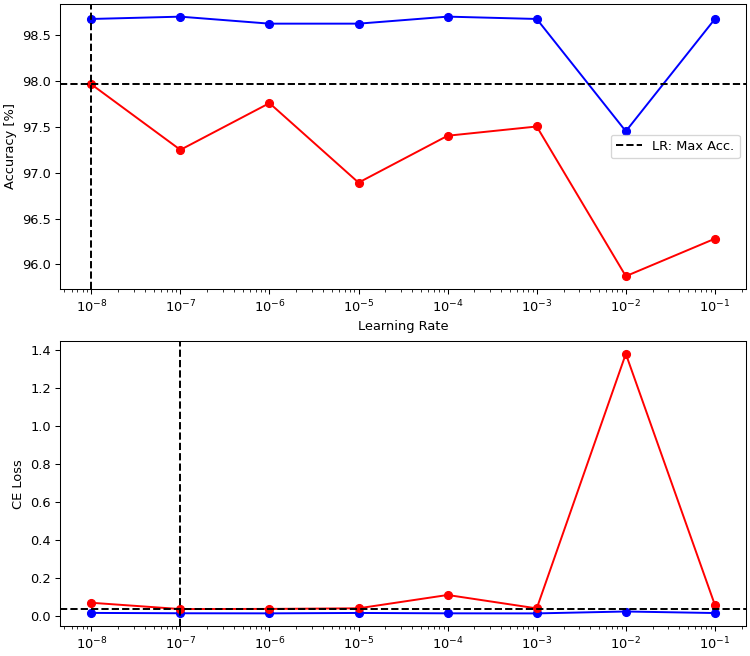

D:\Anaconda_installation\lib\site-packages\matplotlib\cbook\__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)
D:\Anaconda_installation\lib\site-packages\matplotlib\cbook\__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the typ

In [26]:
%matplotlib notebook
fig2, ax2 = plt.subplots(2,1,figsize = (8,7),layout = 'constrained')

ax2[0].plot(LR,acc_train_grid,color='b',marker = 'o')
ax2[0].plot(LR,acc_test_grid,color='r',marker = 'o')
ax2[0].set_xlabel("Learning Rate")
ax2[0].set_ylabel("Accuracy [%]")
ax2[0].axhline(max_acc,linestyle = '--',color='k')
ax2[0].axvline(max_acc_lr,linestyle = '--',color='k',label = 'LR: Max Acc.')
ax2[0].legend()
ax2[0].set_xscale('log')
ax2[1].set_xscale('log')


ax2[1].plot(LR,loss_train_grid,color='b',marker = 'o')
ax2[1].plot(LR,loss_test_grid,color='r',marker = 'o')
ax2[1].set_ylabel("Learning Rate")
ax2[1].set_ylabel("CE Loss")
ax2[1].axhline(min_loss,linestyle = '--',color='k')
ax2[1].axvline(min_loss_lr,linestyle = '--',color='k',label = 'LR: Min Loss')


In [27]:
plt.savefig('model_rprop_lr_test2',dpi = 200)